![](https://wherobots.com/wp-content/uploads/2023/12/Inline-Blue_Black_onWhite@3x.png)

# Raster Data Analysis With Spatial SQL & Sedona

Let's explore working with raster data in Sedona and Wherobots Cloud. This notebook covers:

* loading a single GeoTiff as a raster
* loading multiple GeoTiffs
* tiling large rasters
* raster / vector join operations
* zonal statistics
* saving rasters as Havasu tables
* raster map algebra
* exporting GeoTiffs

You can find more information on working with rasters in the [documentation here.](https://docs.wherobots.services/1.2.1/references/sedonadb/raster-data/Overview/)

In [1]:
from sedona.spark import *
from pyspark.sql.functions import expr
from IPython.display import display, HTML
import rasterio
from matplotlib import pyplot

In [2]:
config = SedonaContext.builder(). \
    config("spark.hadoop.fs.s3a.bucket.wherobots-examples.aws.credentials.provider","org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    getOrCreate()

sedona = SedonaContext.create(config)

24/02/29 15:10:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/29 15:10:43 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
24/02/29 15:10:44 WARN S3ABlockOutputStream: Application invoked the Syncable API against stream writing to qjnq6fcbf1/spark-logs/spark-3ca049c8cf2c4c0fa188d596eefdc4d0.inprogress. This is unsupported
24/02/29 15:11:26 WARN SedonaContext: Python files are not set. Sedona will not pre-load Python UDFs.


## Raster Data Overview

Raster data is gridded data where each pixel has one or more values associated with it (bands) and references a geographic location. Common raster data include aerial imagery, elevation models, precipitation maps, and population datasets.

![](https://wherobots.com/wp-content/uploads/2024/02/raster_concept.png)

*[image source: NEON](https://www.neonscience.org/)*


When working with raster data in Sedona we store rasters and their associated metadata as rows in a table and query them using Spatial SQL.

![](https://wherobots.com/wp-content/uploads/2024/02/earth_observation_table.png)


One of the tools available to us when analyzing raster data is map algebra: performing calculations using the pixel values.

![](https://wherobots.com/wp-content/uploads/2024/02/map_algebra.png)


## Load A Single Raster

Sedona supports a number of raster data formats, including Arc/Info ASCII grid, NetCDF, and GeoTiff. See [raster loaders documentation page](https://docs.wherobots.services/1.2.1/references/sedonadb/raster-data/Raster-loader/) for more.

Rasters can be loaded as "out-of-database" (out-db) rasters from a remote file path, "in-database" (in-db). Out-db allows for managing large raster datasets stored on cloud storage, efficient handling of remote data, while in-db is useful when the raster data needs to managed within the database (data integrity / access efficiency, etc)


### `RS_FromPath` - Create an out-db raster from remote file path

Let's load a single high-resolution aerial image from the [NEON dataset.](https://data.neonscience.org/data-products/DP3.30010.001)

In [3]:
file_url = "s3://wherobots-examples/data/examples/NEON_ortho.tif"
neon_df = sedona.sql(f"SELECT RS_FromPath('{file_url}') AS raster")

In [4]:
neon_df.createOrReplaceTempView("neon")
neon_df.printSchema()

root
 |-- raster: raster (nullable = true)



In [5]:
neon_df.show(truncate=False)

+---------------------------------------+
|raster                                 |
+---------------------------------------+
|LazyLoadOutDbGridCoverage2D[not loaded]|
+---------------------------------------+



In [6]:
sedona.sql("SELECT RS_MetaData(raster) from neon").show(truncate=False)

+------------------------------------------------------------------------+
|rs_metadata(raster)                                                     |
+------------------------------------------------------------------------+
|[470000.0, 7228000.0, 1000.0, 1000.0, 1.0, -1.0, 0.0, 0.0, 32606.0, 3.0]|
+------------------------------------------------------------------------+



In [7]:
sedona.sql("SELECT RS_NumBands(raster) FROM neon").show()

+-------------------+
|rs_numbands(raster)|
+-------------------+
|                  3|
+-------------------+



,"rs_asimage(raster, 500)"
0,

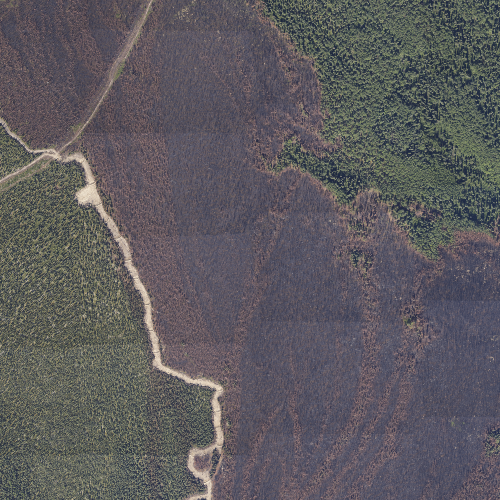

In [8]:
htmlDf = sedona.sql("SELECT RS_AsImage(raster, 500) FROM neon")
SedonaUtils.display_image(htmlDf)

In [9]:
sedona.sql("SELECT RS_Values(raster, Array(ST_SetSRID(ST_Point(470000, 7227880), 32606)), 2) FROM neon").show(truncate=False)

+-------------------------------------------------------------------------+
|rs_values(raster, array(st_setsrid(st_point(470000, 7227880), 32606)), 2)|
+-------------------------------------------------------------------------+
|[104.0]                                                                  |
+-------------------------------------------------------------------------+



### Map Algebra Operations

Performing raster math is one of the most common and powerful raster workflows (used for example to compute spectral indexes). Sedona supports a number of band-specific raster math operations such as:

* `RS_Add`, `RS_Divide`, `RS_Mean`, `RS_NormalizedDifference`, etc
* [`RS_MapAlgebra`](https://docs.wherobots.services/1.2.1/references/sedonadb/raster-data/Raster-map-algebra/)


### [`RS_MapAlgebra`](https://docs.wherobots.services/1.2.1/references/sedonadb/raster-data/Raster-map-algebra/)

Used to apply a map algebra script on a raster (or multiple rasters). For example to calculate NDVI or AWEI. 

Let's calculate the Normalized Difference Greenness Index (Escadafal & Huete 1991) for our raster 

\begin{equation*}
{NDGI} = \frac{G-R}{G+R}
\end{equation*}


In [10]:
ndgi_df = sedona.sql("""
SELECT 
  RS_MapAlgebra(raster, 'D', 'out = ((rast[1] - rast[0]) / (rast[1] + rast[0]));') 
AS raster
FROM neon
""")

In [11]:
ndgi_df.createOrReplaceTempView("ndgi")
ndgi_df.printSchema()

root
 |-- raster: raster (nullable = true)



In [12]:
sedona.sql("SELECT RS_NumBands(raster) FROM ndgi").show()

+-------------------+
|rs_numbands(raster)|
+-------------------+
|                  1|
+-------------------+



In [13]:
sedona.sql("SELECT RS_SummaryStats(raster) FROM ndgi").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------+
|rs_summarystats(raster)                                                                                               |
+----------------------------------------------------------------------------------------------------------------------+
|[1000000.0, -10863.97160595989, -0.010863971605958938, 0.045695423898689726, -0.1493212669683258, 0.18421052631578946]|
+----------------------------------------------------------------------------------------------------------------------+



In [14]:
sedona.sql("SELECT RS_Values(raster, Array(ST_SetSRID(ST_Point(470000, 7227880), 32606)), 1) FROM ndgi").show(truncate=False)

+-------------------------------------------------------------------------+
|rs_values(raster, array(st_setsrid(st_point(470000, 7227880), 32606)), 1)|
+-------------------------------------------------------------------------+
|[-0.09956709956709957]                                                   |
+-------------------------------------------------------------------------+



In [15]:
sedona.sql("SELECT RS_Values(raster, Array(ST_SetSRID(ST_Point(470700, 7228000), 32606)), 1) FROM ndgi").show(truncate=False)

+-------------------------------------------------------------------------+
|rs_values(raster, array(st_setsrid(st_point(470700, 7228000), 32606)), 1)|
+-------------------------------------------------------------------------+
|[0.03636363636363636]                                                    |
+-------------------------------------------------------------------------+



In [16]:
binary_raster_df = sedona.sql("SELECT RS_AsGeoTiff(raster) AS raster FROM ndgi")

In [17]:
binary_raster_df.write.format("raster").mode("overwrite").save("ndgi.tif")

## Load Multiple Rasters

Previously we saw loading a single raster into a single row. We typically work with many rasters across many rows. Let's load a raster dataset from the [WorldClim historical climate dataset](https://www.worldclim.org/data/worldclim21.html) of precipitation from 1970-2000. Each raster file represents the average precipitation across all years for each month of the year.


In [18]:
PREC_URL = "s3://wherobots-examples/data/examples/world_clim/wc2.1_10m_prec" #/wc2.1_10m_prec_01.tif

In [19]:
rawDf = sedona.read.format("binaryFile").load(PREC_URL + "/*.tif")
rawDf.createOrReplaceTempView("rawdf")
rawDf.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://wherobots-ex...|2024-02-28 19:59:56|669568|[49 49 2A 00 08 0...|
|s3://wherobots-ex...|2024-02-28 19:59:55|642783|[49 49 2A 00 08 0...|
|s3://wherobots-ex...|2024-02-28 19:59:57|632536|[49 49 2A 00 08 0...|
|s3://wherobots-ex...|2024-02-28 19:59:56|628584|[49 49 2A 00 08 0...|
|s3://wherobots-ex...|2024-02-28 19:59:58|624869|[49 49 2A 00 08 0...|
|s3://wherobots-ex...|2024-02-28 19:59:58|619008|[49 49 2A 00 08 0...|
|s3://wherobots-ex...|2024-02-28 20:00:00|615937|[49 49 2A 00 08 0...|
|s3://wherobots-ex...|2024-02-28 19:59:59|615576|[49 49 2A 00 08 0...|
|s3://wherobots-ex...|2024-02-28 19:59:54|594226|[49 49 2A 00 08 0...|
|s3://wherobots-ex...|2024-02-28 19:59:53|581807|[49 49 2A 00 08 0...|
|s3://wherobots-ex...|2024-02-28 20:00:00|576683|[49 49 2A 00 08 0...|
|s3://

In [20]:
rasterDf = sedona.sql("""
SELECT 
  RS_FromGeoTiff(content) AS raster, 
  Int(regexp_extract(path, '(.*)([0-9]{2}).tif', 2)) AS month
FROM rawdf
""")

rasterDf.createOrReplaceTempView("prec")
rasterDf.printSchema()

root
 |-- raster: raster (nullable = true)
 |-- month: integer (nullable = true)



In [21]:
sedona.sql("SELECT RS_MetaData(raster) FROM prec").show(truncate=False) 

+------------------------------------------------------------------------------------------------+
|rs_metadata(raster)                                                                             |
+------------------------------------------------------------------------------------------------+
|[-180.0, 90.0, 2160.0, 1080.0, 0.16666666666666666, -0.16666666666666666, 0.0, 0.0, 4326.0, 1.0]|
|[-180.0, 90.0, 2160.0, 1080.0, 0.16666666666666666, -0.16666666666666666, 0.0, 0.0, 4326.0, 1.0]|
|[-180.0, 90.0, 2160.0, 1080.0, 0.16666666666666666, -0.16666666666666666, 0.0, 0.0, 4326.0, 1.0]|
|[-180.0, 90.0, 2160.0, 1080.0, 0.16666666666666666, -0.16666666666666666, 0.0, 0.0, 4326.0, 1.0]|
|[-180.0, 90.0, 2160.0, 1080.0, 0.16666666666666666, -0.16666666666666666, 0.0, 0.0, 4326.0, 1.0]|
|[-180.0, 90.0, 2160.0, 1080.0, 0.16666666666666666, -0.16666666666666666, 0.0, 0.0, 4326.0, 1.0]|
|[-180.0, 90.0, 2160.0, 1080.0, 0.16666666666666666, -0.16666666666666666, 0.0, 0.0, 4326.0, 1.0]|
|[-180.0, 

In [22]:
sedona.sql("SELECT month, RS_SummaryStats(raster) FROM prec ORDER BY month ASC").show(truncate=False)

+-----+---------------------------------------------------------------------------+
|month|rs_summarystats(raster)                                                    |
+-----+---------------------------------------------------------------------------+
|1    |[808053.0, 3.2816839E7, 40.612235831036806, 71.58202261528564, 0.0, 908.0] |
|2    |[808053.0, 3.110572E7, 38.49465319724863, 65.22884915327343, 0.0, 793.0]   |
|3    |[808053.0, 3.4943215E7, 43.24371668684569, 67.88342263061789, 0.0, 720.0]  |
|4    |[808053.0, 3.4283833E7, 42.42770338082592, 61.129070691979166, 0.0, 1004.0]|
|5    |[808053.0, 3.6639583E7, 45.34304432999431, 63.51998004686114, 0.0, 2068.0] |
|6    |[808053.0, 3.8714648E7, 47.9110256382872, 72.94226238575892, 0.0, 2210.0]  |
|7    |[808053.0, 4.6393435E7, 57.413851566716545, 82.74978674918007, 0.0, 2381.0]|
|8    |[808053.0, 4.8515628E7, 60.040155782001115, 76.31015675449926, 0.0, 1674.0]|
|9    |[808053.0, 3.9648388E7, 49.06656865321915, 66.55061748894705, 0.0, 19

In [23]:
sedona.sql("""
SELECT 
  month, 
  RS_Values(raster, Array(ST_POINT(-113.9940, 46.8721))) AS avg_prec 
  FROM prec ORDER BY month ASC
""").show(truncate=False)

+-----+--------+
|month|avg_prec|
+-----+--------+
|1    |[43.0]  |
|2    |[27.0]  |
|3    |[31.0]  |
|4    |[31.0]  |
|5    |[50.0]  |
|6    |[49.0]  |
|7    |[27.0]  |
|8    |[31.0]  |
|9    |[31.0]  |
|10   |[29.0]  |
|11   |[35.0]  |
|12   |[40.0]  |
+-----+--------+



### Zonal Statistics

Zonal statistics involves joining vector geometries to the raster and calculating statistical or aggregating values based on the pixel values within each vector geometry.

In [24]:
countries = ShapefileReader.readToGeometryRDD(sedona, 's3://wherobots-examples/data/examples/natural_earth/ne_10m_admin_0_countries')
countries_df = Adapter.toDf(countries, sedona)
countries_df.createOrReplaceTempView("countries")
countries_df.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- featurecla: string (nullable = true)
 |-- scalerank: string (nullable = true)
 |-- LABELRANK: string (nullable = true)
 |-- SOVEREIGNT: string (nullable = true)
 |-- SOV_A3: string (nullable = true)
 |-- ADM0_DIF: string (nullable = true)
 |-- LEVEL: string (nullable = true)
 |-- TYPE: string (nullable = true)
 |-- TLC: string (nullable = true)
 |-- ADMIN: string (nullable = true)
 |-- ADM0_A3: string (nullable = true)
 |-- GEOU_DIF: string (nullable = true)
 |-- GEOUNIT: string (nullable = true)
 |-- GU_A3: string (nullable = true)
 |-- SU_DIF: string (nullable = true)
 |-- SUBUNIT: string (nullable = true)
 |-- SU_A3: string (nullable = true)
 |-- BRK_DIFF: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- NAME_LONG: string (nullable = true)
 |-- BRK_A3: string (nullable = true)
 |-- BRK_NAME: string (nullable = true)
 |-- BRK_GROUP: string (nullable = true)
 |-- ABBREV: string (nullable = true)
 |-- POSTAL: string (

24/02/29 15:11:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [25]:
world_prec_df = sedona.sql("""
SELECT 
  sum(RS_ZonalStats(prec.raster, countries.geometry, 1, 'avg', true)) AS yearly_avg_prec,  
  any_value(countries.geometry), 
  countries.name
FROM prec, countries
GROUP BY name
ORDER BY yearly_avg_prec DESC
""")

In [26]:
world_prec_df.dropna().show()

+------------------+--------------------+--------------------+
|   yearly_avg_prec| any_value(geometry)|                name|
+------------------+--------------------+--------------------+
|            4937.5|MULTIPOLYGON (((1...|          Micronesia|
|            3526.0|MULTIPOLYGON (((1...|               Palau|
|           3378.75|MULTIPOLYGON (((-...|               Samoa|
|         3345.6875|MULTIPOLYGON (((1...|              Brunei|
| 3234.474358974359|MULTIPOLYGON (((1...|         Solomon Is.|
|            3111.0|MULTIPOLYGON (((-...|        Saint Helena|
|            3008.0|MULTIPOLYGON (((-...|Wallis and Futuna...|
| 2988.550872093023|MULTIPOLYGON (((1...|    Papua New Guinea|
|2934.6285714285714|MULTIPOLYGON (((1...|             Vanuatu|
|2881.2202505219207|MULTIPOLYGON (((1...|            Malaysia|
|            2831.0|MULTIPOLYGON (((-...|          Costa Rica|
|            2807.0|MULTIPOLYGON (((-...|          Faeroe Is.|
|2733.1463857609974|MULTIPOLYGON (((1...|           Ind

In [27]:
SedonaKepler.create_map(world_prec_df.dropna())

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

## Tiling Rasters

If we have large rasters we typically want to break them up into multiple tiles to improve the efficiency of raster operations. Let's take a look at an example using a [dataset from NOAA of night time visible lights](https://www.ncei.noaa.gov/products/dmsp-operational-linescan-system).

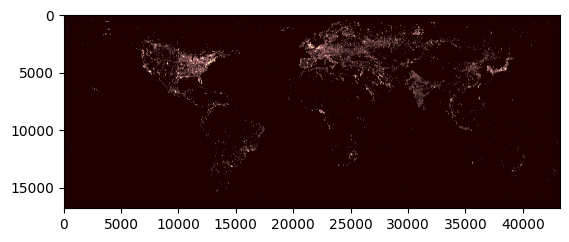

In [28]:
src = rasterio.open("data/F101993.v4b.global.stable_lights.avg_vis.tif")
array = src.read(1)
pyplot.imshow(array, cmap='pink')

In [29]:
f10_1993_uri = "s3://wherobots-examples/data/examples/DMSP_OLS/F101993.v4b.global.stable_lights.avg_vis.tif"
f10_1993_df = sedona.sql(f"SELECT RS_FromPath('{f10_1993_uri}') AS raster")
f10_1993_df.createOrReplaceTempView("f10_1993")
f10_1993_df.show(truncate=False)

+---------------------------------------+
|raster                                 |
+---------------------------------------+
|LazyLoadOutDbGridCoverage2D[not loaded]|
+---------------------------------------+



In [30]:
tile_df = sedona.sql("SELECT RS_TileExplode(raster, 256, 256) AS (x, y, tile) FROM f10_1993")
tile_df.show(5)

+---+---+--------------------+
|  x|  y|                tile|
+---+---+--------------------+
|  0|  0|OutDbGridCoverage...|
|  1|  0|OutDbGridCoverage...|
|  2|  0|OutDbGridCoverage...|
|  3|  0|OutDbGridCoverage...|
|  4|  0|OutDbGridCoverage...|
+---+---+--------------------+
only showing top 5 rows



In [31]:
sedona.sql("DROP TABLE IF EXISTS wherobots.test_db.f10_1993")
tile_df.writeTo("wherobots.test_db.f10_1993").create()

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".                
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


In [32]:
sedona.table("wherobots.test_db.f10_1993").count()

11154

In [33]:
sedona.table("wherobots.test_db.f10_1993").show()

tiledMap = SedonaKepler.create_map()
SedonaKepler.add_df(tiledMap, sedona.table("wherobots.test_db.f10_1993").withColumn("tile", expr("RS_Envelope(tile)")), name="tiles")
tiledMap

+---+---+--------------------+
|  x|  y|                tile|
+---+---+--------------------+
|  0|  0|OutDbGridCoverage...|
|  1|  0|OutDbGridCoverage...|
|  2|  0|OutDbGridCoverage...|
|  3|  0|OutDbGridCoverage...|
|  4|  0|OutDbGridCoverage...|
|  5|  0|OutDbGridCoverage...|
|  6|  0|OutDbGridCoverage...|
|  7|  0|OutDbGridCoverage...|
|  8|  0|OutDbGridCoverage...|
|  9|  0|OutDbGridCoverage...|
| 10|  0|OutDbGridCoverage...|
| 11|  0|OutDbGridCoverage...|
| 12|  0|OutDbGridCoverage...|
| 13|  0|OutDbGridCoverage...|
| 14|  0|OutDbGridCoverage...|
| 15|  0|OutDbGridCoverage...|
| 16|  0|OutDbGridCoverage...|
| 17|  0|OutDbGridCoverage...|
| 18|  0|OutDbGridCoverage...|
| 19|  0|OutDbGridCoverage...|
+---+---+--------------------+
only showing top 20 rows

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'tiles': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2…

In [34]:
sedona.sql("SELECT RS_NumBands(raster) FROM f10_1993").show()

+-------------------+
|rs_numbands(raster)|
+-------------------+
|                  1|
+-------------------+



,"rs_asimage(tile, 200)",rs_envelope(tile)
0,,"POLYGON ((-180.00416666665 72.87083334185, -180.00416666665 75.00416666665, -177.87083334185 75.00416666665, -177.87083334185 72.87083334185, -180.00416666665 72.87083334185))"
1,,"POLYGON ((-177.87083334185002 72.87083334185, -177.87083334185002 75.00416666665, -175.73750001705 75.00416666665, -175.73750001705 72.87083334185, -177.87083334185002 72.87083334185))"
2,,"POLYGON ((-175.73750001705 72.87083334185, -175.73750001705 75.00416666665, -173.60416669224998 75.00416666665, -173.60416669224998 72.87083334185, -175.73750001705 72.87083334185))"
3,,"POLYGON ((-173.60416669225 72.87083334185, -173.60416669225 75.00416666665, -171.47083336744998 75.00416666665, -171.47083336744998 72.87083334185, -173.60416669225 72.87083334185))"
4,,"POLYGON ((-171.47083336745 72.87083334185, -171.47083336745 75.00416666665, -169.33750004265 75.00416666665, -169.33750004265 72.87083334185, -171.47083336745 72.87083334185))"

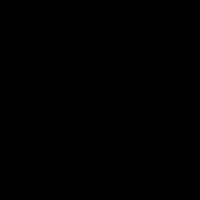
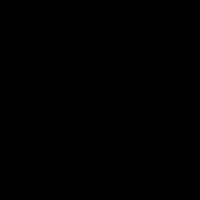
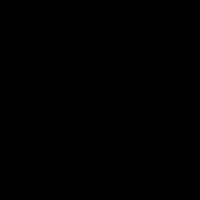
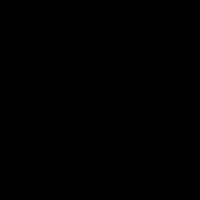
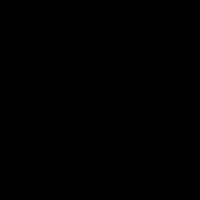

In [35]:
display(HTML(sedona.table("wherobots.test_db.f10_1993").selectExpr("RS_AsImage(tile, 200)", "RS_Envelope(tile)").limit(5).toPandas().to_html(escape=False)))

In [36]:
sedona.sql("""
WITH matched_tile AS (
  SELECT * FROM wherobots.test_db.f10_1993 
  WHERE RS_Intersects(tile, ST_POINT(-113.9940, 46.8721))
)

SELECT RS_Values(tile, Array(ST_POINT(-113.9940, 46.8721))) 
FROM matched_tile

""").show(truncate=False)

+----------------------------------------------------+
|rs_values(tile, array(st_point(-113.9940, 46.8721)))|
+----------------------------------------------------+
|[63.0]                                              |
+----------------------------------------------------+



In [37]:
counties_shapefile = "s3://wherobots-examples/data/examples/natural_earth/ne_10m_admin_2_counties"

In [38]:
spatialRDD = ShapefileReader.readToGeometryRDD(sedona, counties_shapefile)
counties_df = Adapter.toDf(spatialRDD, sedona)
counties_df.createOrReplaceTempView("counties")
counties_df.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- FEATURECLA: string (nullable = true)
 |-- SCALERANK: string (nullable = true)
 |-- ADM2_CODE: string (nullable = true)
 |-- ISO_3166_2: string (nullable = true)
 |-- ISO_A2: string (nullable = true)
 |-- ADM0_SR: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- NAME_ALT: string (nullable = true)
 |-- NAME_LOCAL: string (nullable = true)
 |-- TYPE: string (nullable = true)
 |-- TYPE_EN: string (nullable = true)
 |-- CODE_LOCAL: string (nullable = true)
 |-- REGION: string (nullable = true)
 |-- REGION_COD: string (nullable = true)
 |-- ABBREV: string (nullable = true)
 |-- AREA_SQKM: string (nullable = true)
 |-- SAMEASCITY: string (nullable = true)
 |-- LABELRANK: string (nullable = true)
 |-- NAME_LEN: string (nullable = true)
 |-- MAPCOLOR9: string (nullable = true)
 |-- MAPCOLOR13: string (nullable = true)
 |-- FIPS: string (nullable = true)
 |-- SOV_A3: string (nullable = true)
 |-- ADM0_A3: string (nullable = tru

In [39]:
county_light_tiled_df = sedona.sql("""
WITH matched_tile AS (
  SELECT tile, geometry, FIPS
  FROM wherobots.test_db.f10_1993, counties
  WHERE RS_Intersects(tile, counties.geometry) 
)

SELECT 
    sum(RS_ZonalStats(matched_tile.tile, matched_tile.geometry, 'mean')) AS mean_light, 
    any_value(matched_tile.geometry) AS geometry, 
    FIPS
FROM matched_tile
GROUP BY FIPS
""")

In [40]:
county_light_tiled_df.createOrReplaceTempView("county_light_1993")

In [41]:
county_light_tiled_df.show(100)

+--------------------+--------------------+-------+
|          mean_light|            geometry|   FIPS|
+--------------------+--------------------+-------+
|   6.563388510224063|MULTIPOLYGON (((-...|US01003|
|   5.303058346553825|POLYGON ((-85.422...|US01019|
|   7.112594570538514|POLYGON ((-86.413...|US01021|
|  2.5223492723492806|POLYGON ((-88.091...|US01025|
|   9.564617731305812|POLYGON ((-85.789...|US01031|
|  13.433770014555993|POLYGON ((-88.130...|US01033|
|   8.240051020408188|POLYGON ((-86.370...|US01037|
|   2.301078582434537|POLYGON ((-86.191...|US01039|
|  0.9495387954422182|POLYGON ((-86.499...|US01041|
|     8.3112128146453|POLYGON ((-85.770...|US01045|
|   2.008212672420753|POLYGON ((-86.916...|US01047|
|   4.339487179487201|POLYGON ((-86.699...|US01053|
|                 NaN|POLYGON ((-85.863...|US01071|
|   21.28748280605236|POLYGON ((-87.026...|US01073|
|  2.8376935397757586|POLYGON ((-88.241...|US01075|
|    9.75868121970662|POLYGON ((-87.529...|US01079|
|  12.044760

In [42]:
SedonaKepler.create_map(county_light_tiled_df)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/opt/conda/lib/python3.10/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…